### Design, train, evaluate and testing a timeseries model to forecasting  next day`s temperature

In [189]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn 
from torch.utils.data import TensorDataset, DataLoader
from torchsummary import summary
from torch import optim


##### see jena weather data which has 14 quantities and sampling evry 10 minutes

In [190]:
dataframe = pd.read_csv("./jena_dataset/jena_climate_2009_2016.csv")

dataframe.head(5)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [191]:
for index , quantity in enumerate(dataframe.columns):
	if index==0:
		print('the first column is the time steps of the records')
	else:
		print(f'feature #{index} is: ',quantity )
	

the first column is the time steps of the records
feature #1 is:  p (mbar)
feature #2 is:  T (degC)
feature #3 is:  Tpot (K)
feature #4 is:  Tdew (degC)
feature #5 is:  rh (%)
feature #6 is:  VPmax (mbar)
feature #7 is:  VPact (mbar)
feature #8 is:  VPdef (mbar)
feature #9 is:  sh (g/kg)
feature #10 is:  H2OC (mmol/mol)
feature #11 is:  rho (g/m**3)
feature #12 is:  wv (m/s)
feature #13 is:  max. wv (m/s)
feature #14 is:  wd (deg)


##### we just consider temperature feature for prediction and sampling that every one houre 

In [192]:
print('number of temperature samples which were recorded every 10 minutes:\t',(dataframe['T (degC)'].shape[0]))

number of temperature samples which were recorded every 10 minutes:	 420451


In [193]:
dataframe.iloc[5::6,[0,2]]


,Date Time,T (degC)
5,01.01.2009 01:00:00,-8.05
11,01.01.2009 02:00:00,-8.88
17,01.01.2009 03:00:00,-8.81
23,01.01.2009 04:00:00,-9.05
29,01.01.2009 05:00:00,-9.63
...,...,...
420425,31.12.2016 19:50:00,-1.65
420431,31.12.2016 20:50:00,-3.46
420437,31.12.2016 21:50:00,-2.48
420443,31.12.2016 22:50:00,-4.09


In [194]:
print('number of temperature samples after hourely sampeling is :\t',(dataframe.iloc[5::6,[0,2]].shape[0]))

number of temperature samples after hourely sampeling is :	 70075


 Plotting the temperature timeseries

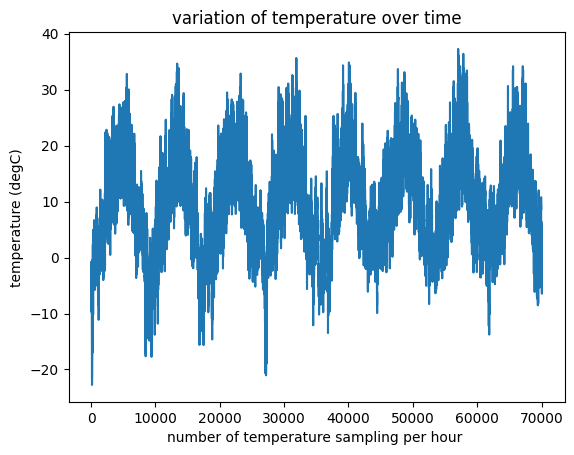

In [195]:
plt.plot(range((dataframe.iloc[5::6,[0,2]].shape[0])), list(dataframe.iloc[5::6,2].values) , '-' )
plt.title('variation of temperature over time')
plt.xlabel('number of temperature sampling per hour ')
plt.ylabel('temperature (degC)')
plt.show()

Plotting the first 30 days of the temperature timeseries

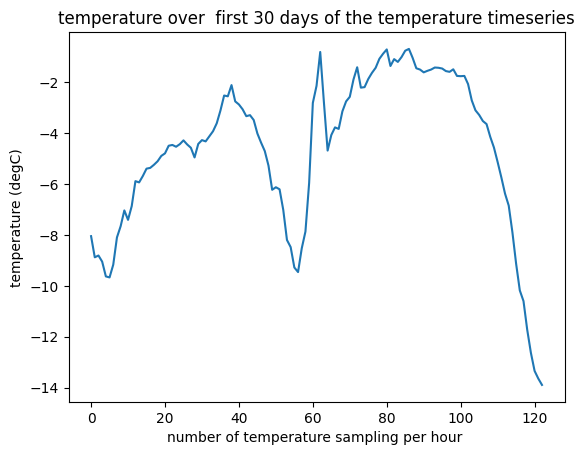

In [196]:
plt.plot(range((dataframe.iloc[5:738:6,[0,2]].shape[0])), list(dataframe.iloc[5:738:6, [2]].values)  )
plt.title('temperature over  first 30 days of the temperature timeseries')
plt.xlabel('number of temperature sampling per hour ')
plt.ylabel('temperature (degC)')
plt.show()

sampling data every one hour and determine size of data for training,validation,testing

In [197]:
dataframe_new = dataframe.iloc[::6 , 1:]


n = len(dataframe_new)
df_train = dataframe_new[0:int(n*0.7)]
df_val = dataframe_new[int(n*0.7):int(n*0.9)]
df_test = dataframe_new[int(n*0.9):]

print(f'total samples of data is:\t\t{n}\nnumber of training samples is:\t\t{len(df_train)}\nnumber of validation samples is:\t{len(df_val)}\nnumber of test samples is:\t\t{len(df_test)}')

total samples of data is:		70076
number of training samples is:		49053
number of validation samples is:	14015
number of test samples is:		7008


normalization data

In [198]:
train_mean = df_train.mean()
train_std = df_train.std()

df_train = (df_train - train_mean) / train_std
df_val = (df_val - train_mean) / train_std
df_test = (df_test - train_mean) / train_std

convert to numpy 

In [199]:
X_train = df_train.to_numpy()
y_train = df_train['T (degC)'].to_numpy()

X_val = df_val.to_numpy()
y_val = df_val['T (degC)'].to_numpy()

X_test = df_test.to_numpy()
y_test = df_test['T (degC)'].to_numpy()

In [200]:
(X_train.shape, y_train.shape), (X_val.shape, y_val.shape), (X_test.shape, y_test.shape)

(((49053, 14), (49053,)), ((14015, 14), (14015,)), ((7008, 14), (7008,)))

convert data to tensor 

In [201]:
X_train = torch.tensor(X_train, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.float32)

X_val = torch.tensor(X_val, dtype = torch.float32)
y_val = torch.tensor(y_val, dtype = torch.float32)

X_test = torch.tensor(X_test, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.float32)

make timeseries dataset 

In [202]:
seq_length = 120   ## five days
pred_length = 24   ## one day

def sequencer(X, y, seq_length, pred_length):

	delay = (seq_length + pred_length - 1)
	
	X_seq = torch.stack([ X[i:i+seq_length ,:]      for i in  range(len(X) - delay ) ])
	y_seq = torch.stack([y[i+seq_length]            for i in  range(len(X) - delay ) ])

	return X_seq, y_seq

In [203]:
X_train_seq, y_train_seq = sequencer(X_train, y_train, seq_length, pred_length)
X_val_seq, y_val_seq = sequencer(X_val, y_val, seq_length, pred_length)
X_test_seq, y_test_seq = sequencer(X_test, y_test, seq_length, pred_length)

In [204]:
(X_train_seq.shape, y_train_seq.shape),(X_val_seq.shape, y_val_seq.shape), (X_test_seq.shape, y_test_seq.shape)

((torch.Size([48910, 120, 14]), torch.Size([48910])),
 (torch.Size([13872, 120, 14]), torch.Size([13872])),
 (torch.Size([6865, 120, 14]), torch.Size([6865])))

In [205]:


train_dataset = TensorDataset(X_train_seq, y_train_seq)
val_dataset = TensorDataset(X_val_seq, y_val_seq)
test_dataset = TensorDataset(X_test_seq, y_test_seq)

create DataLoader for train,validation and test data

In [206]:
batch_size = 512

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = False)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

define  RNN-model

In [207]:
class model_LSTM(nn.Module):
	def __init__(self, input_size, hidden_size, batch_first = True, num_layers = 1):
		super().__init__()
		self.lstm = nn.LSTM(input_size=input_size, 
							hidden_size=hidden_size, 
							num_layers=num_layers, 
							batch_first=batch_first) 
		 
		self.dropout = nn.Dropout(p=0.3)

		self.fc = nn.Linear(hidden_size, 1)

	def forward(self, x):
		out, (h,c) = self.lstm(x)
		dropout = self.dropout(out)
		out = self.fc(dropout[:,-1,:] )

		return out

specifying device

In [208]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


specifying  optimizer, loss function, instantioate model

In [209]:
input_size = 14   
hidden_size = 32
model = model_LSTM(input_size, hidden_size, batch_first = True, num_layers = 2)


model = model.to(device)


loss_fn = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr = 0.001)

In [210]:
summary(model, torch.zeros(1,120,14))

Layer (type:depth-idx)                   Output Shape              Param #
├─LSTM: 1-1                              [-1, 120, 32]             14,592
├─Dropout: 1-2                           [-1, 120, 32]             --
├─Linear: 1-3                            [-1, 1]                   33
Total params: 14,625
Trainable params: 14,625
Non-trainable params: 0
Total mult-adds (M): 0.01
Input size (MB): 0.01
Forward/backward pass size (MB): 0.03
Params size (MB): 0.06
Estimated Total Size (MB): 0.09


Layer (type:depth-idx)                   Output Shape              Param #
├─LSTM: 1-1                              [-1, 120, 32]             14,592
├─Dropout: 1-2                           [-1, 120, 32]             --
├─Linear: 1-3                            [-1, 1]                   33
Total params: 14,625
Trainable params: 14,625
Non-trainable params: 0
Total mult-adds (M): 0.01
Input size (MB): 0.01
Forward/backward pass size (MB): 0.03
Params size (MB): 0.06
Estimated Total Size (MB): 0.09

start training model 

In [211]:
epochs = 30

for epoch in range(epochs):
	
	train_loss = 0
	val_loss = 0

	# Training loop
	model.train()
	for x, y in train_loader:
	   
		inputs = x.to(device)
		target = y.to(device)
		
		optimizer.zero_grad()

	  
		preds = model(inputs)
		loss = loss_fn(preds.view(-1,), target)  

		
		loss.backward()
		optimizer.step()

		
		train_loss += loss.item()

	# Validation loop
	model.eval()
	with torch.no_grad():
		for x, y in val_loader:

			inputs = x.to(device)
			target = y.to(device)

			
			preds = model(inputs)
			loss = loss_fn(preds.view(-1,), target)  

		   
			val_loss += loss.item()

	# Calculate average losses
	avg_train_loss = train_loss / len(train_loader)
	avg_val_loss = val_loss / len(val_loader)


	print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")



	

Epoch 1/30, Train Loss: 0.4081, Val Loss: 0.1080
Epoch 2/30, Train Loss: 0.1197, Val Loss: 0.0562
Epoch 3/30, Train Loss: 0.0727, Val Loss: 0.0362
Epoch 4/30, Train Loss: 0.0610, Val Loss: 0.0291
Epoch 5/30, Train Loss: 0.0499, Val Loss: 0.0225
Epoch 6/30, Train Loss: 0.0427, Val Loss: 0.0176
Epoch 7/30, Train Loss: 0.0362, Val Loss: 0.0166
Epoch 8/30, Train Loss: 0.0331, Val Loss: 0.0156
Epoch 9/30, Train Loss: 0.0403, Val Loss: 0.0143
Epoch 10/30, Train Loss: 0.0303, Val Loss: 0.0120
Epoch 11/30, Train Loss: 0.0260, Val Loss: 0.0105
Epoch 12/30, Train Loss: 0.0286, Val Loss: 0.0123
Epoch 13/30, Train Loss: 0.0270, Val Loss: 0.0104
Epoch 14/30, Train Loss: 0.0307, Val Loss: 0.0114
Epoch 15/30, Train Loss: 0.0268, Val Loss: 0.0101
Epoch 16/30, Train Loss: 0.0325, Val Loss: 0.0113
Epoch 17/30, Train Loss: 0.0242, Val Loss: 0.0081
Epoch 18/30, Train Loss: 0.0258, Val Loss: 0.0093
Epoch 19/30, Train Loss: 0.0244, Val Loss: 0.0083
Epoch 20/30, Train Loss: 0.0285, Val Loss: 0.0099
Epoch 21/

save trained model

In [212]:

save_model_path = './lstm_model_epoch_30.pth'
torch.save(model.state_dict(), save_model_path)

#### Evaluate model on testing data

In [213]:

path_to_saved_model = './lstm_model_epoch_30.pth'
model.load_state_dict(torch.load(path_to_saved_model, weights_only=True))

model.eval()
predictions, truths = [], []
	
with torch.no_grad():
	for X, y in test_loader:
		
		X, y = X.to(device), y.to(device)
		preds = model(X).cpu().numpy()
		
		y = y.cpu().numpy()  
			
			
		predictions.extend(preds.tolist())
		truths.extend(y.tolist())



prediction = np.array(predictions)
truths = np.array(truths)

plot prediction of trained model on unseen data

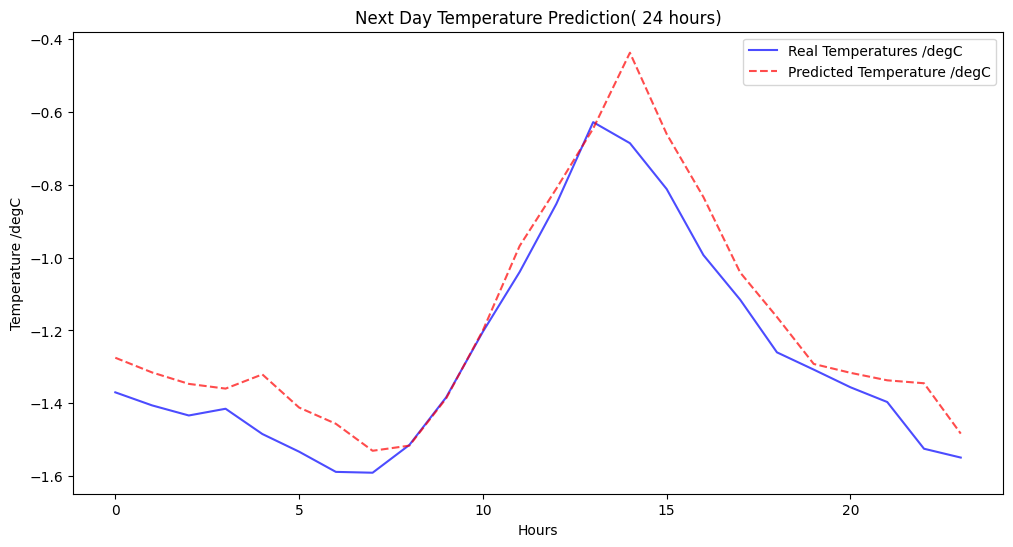

In [214]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(truths[-24:])),   truths[-24:],  'b'  ,    label='Real Temperatures /degC',    alpha=0.7)
plt.plot(range(len(prediction[-24:])),   prediction[-24:],  'r--' ,  label='Predicted Temperature /degC',  alpha=0.7)
plt.title("Next Day Temperature Prediction( 24 hours)")
plt.xlabel("Hours")
plt.ylabel("Temperature /degC")
plt.legend()
plt.show()


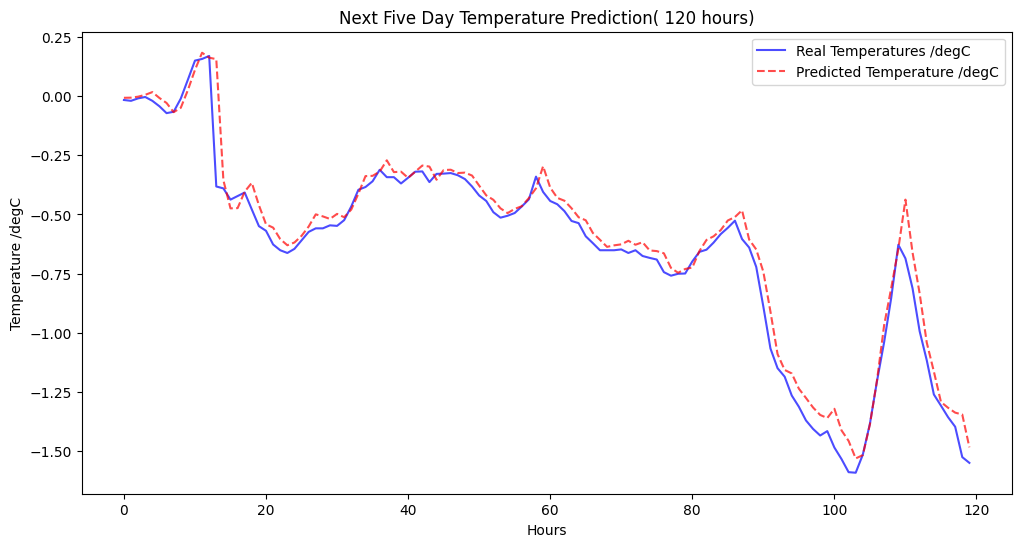

In [215]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(truths[-120:])),   truths[-120:],  'b'  ,    label='Real Temperatures /degC',    alpha=0.7)
plt.plot(range(len(prediction[-120:])),   prediction[-120:],  'r--' ,  label='Predicted Temperature /degC',  alpha=0.7)
plt.title("Next Five Day Temperature Prediction( 120 hours)")
plt.xlabel("Hours")
plt.ylabel("Temperature /degC")
plt.legend()
plt.show()